In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

sns.set_style('whitegrid')

# Part A: Data Exploration and Baseline Model 


## 1. Load and Analyze the Dataset

In [67]:
df = pd.read_csv('creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [68]:
df.shape

(284807, 31)

## 2. Analyze Class Distribution

In [69]:
# Get the count of each class
counts = df['Class'].value_counts().sort_index()
print(counts)

Class
0    284315
1       492
Name: count, dtype: int64


In [70]:
# Calculate the percentage of fraudulent transactions
fraud_percentage = (counts[1] / counts.sum()) * 100
print(f"\nDegree of Imbalance: Fraudulent transactions make up {fraud_percentage:.4f}% of the dataset.")


Degree of Imbalance: Fraudulent transactions make up 0.1727% of the dataset.


/var/folders/yf/hrhf1sp93cs_t7mxbv6_5k600000gn/T/ipykernel_8374/2870755990.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='colorblind')


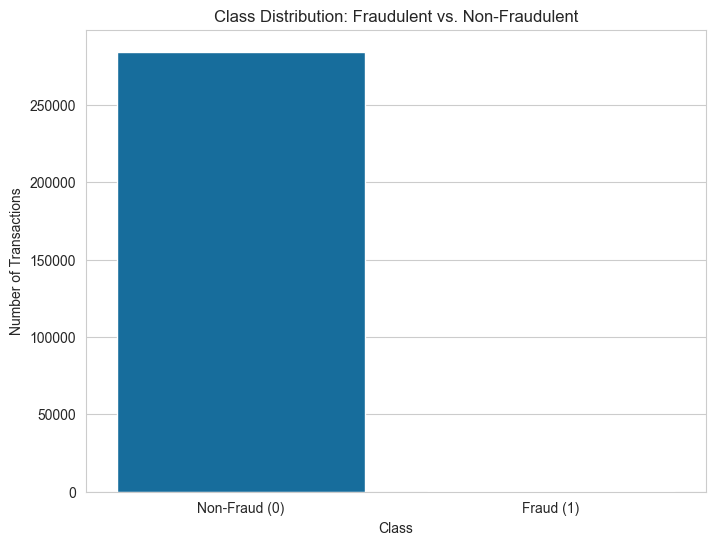

In [71]:
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='colorblind')
plt.title('Class Distribution: Fraudulent vs. Non-Fraudulent')
plt.xticks([0,1], ['Non-Fraud (0)','Fraud (1)'])
plt.ylabel('Number of Transactions')
plt.show()

The dataset exhibits a significant class imbalance. Fraudulent transactions (Class 1) constitute only 0.1727% of the total observations. This disparity is visually confirmed by the bar chart, which illustrates that the volume of non-fraudulent transactions (Class 0) is substantially greater than that of fraudulent ones. Such an imbalance presents a notable challenge, as a standard classification model may achieve high accuracy by being biased towards the majority class, thereby failing to effectively identify the critical minority class.

## 3. Baseline Model:

In [72]:
X = df.drop('Class', axis=1)
y = df['Class']

In [73]:
# Using stratify=y to ensure the class proportion is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [74]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

In [75]:
# scale Amount and Time
X_train_scaled[['Amount','Time']] = scaler.fit_transform(X_train[['Amount','Time']])
X_test_scaled[['Amount','Time']]  = scaler.transform(X_test[['Amount','Time']])

We scale numeric features after splitting to avoid data leakage. Resampling will be applied only to the training set in its scaled form.

### Logistic Regression on imbalanced training set

In [76]:
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(X_train_scaled, y_train)

y_pred_1 = model_1.predict(X_test_scaled)

print("Baseline Model (Model 1) Performance on Imbalanced Test Set:")
print(classification_report(y_test, y_pred_1, target_names=['Non-Fraud (0)', 'Fraud (1)']))


Baseline Model (Model 1) Performance on Imbalanced Test Set:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     56864
    Fraud (1)       0.83      0.64      0.72        98

     accuracy                           1.00     56962
    macro avg       0.91      0.82      0.86     56962
 weighted avg       1.00      1.00      1.00     56962



#### Why Accuracy is a Misleading Metric

Accuracy is a highly misleading metric in this scenario due to the severe class imbalance. Our baseline model (Model 1) achieves **nearly 100% accuracy**, which at first glance seems like a perfect score. However, this number is deceptive because it's **overwhelmingly influenced** by the model's correct prediction of the majority (Non-Fraud) class.

The true performance is revealed by looking at the metrics for the minority (Fraud) class. A 

**recall of 0.64** indicates that the model is only identifying 64% of the actual fraudulent transactions, meaning it misses 36% of them entirely. For a fraud detection system, failing to catch over a third of fraudulent cases is a critical flaw that the overall accuracy score completely hides.

Therefore, metrics like **Precision, Recall, and the F1-score** are far more useful here. They specifically evaluate the model's ability to handle the rare but crucial fraud class, providing a much more realistic assessment of its performance.

# Part B: Resampling Approaches

## 1. Naive Oversampling (SMOTE)

### How SMOTE works and its limitations?

SMOTE (Synthetic Minority Over-sampling Technique) works by creating 'synthetic' data points rather than just duplicating existing ones. For each minority instance, it identifies its k-nearest minority neighbors. It then creates a new sample at a randomly selected point along the line segment connecting the instance and one of its neighbors. A key limitation is that if the minority class is noisy or overlaps with the majority class, SMOTE can generate new noisy samples in these ambiguous regions, potentially worsening the model's performance.

In [77]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

print("Class Distribution After SMOTE:")
print(pd.Series(y_smote).value_counts())

/Users/khushismac/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Class Distribution After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


## 2. Clustering-Based Oversampling (CBO)

**Clustering-Based Oversampling (CBO)** aims to improve upon naive oversampling by preserving the internal structure of the minority class. The process involves first applying a clustering algorithm (like K-Means) to the minority samples to identify distinct sub-groups. Then, instead of oversampling the entire class uniformly, it oversamples from each of these clusters. This ensures that rarer sub-groups within the minority class are adequately represented in the final training set, promoting diversity and avoiding the generation of synthetic data in sparse regions.

In [78]:
# Separate minority and majority classes from the training set
X_train_minority = X_train_scaled[y_train == 1]
X_train_majority = X_train_scaled[y_train == 0]
y_train_minority = y_train[y_train == 1]
y_train_majority = y_train[y_train == 0]

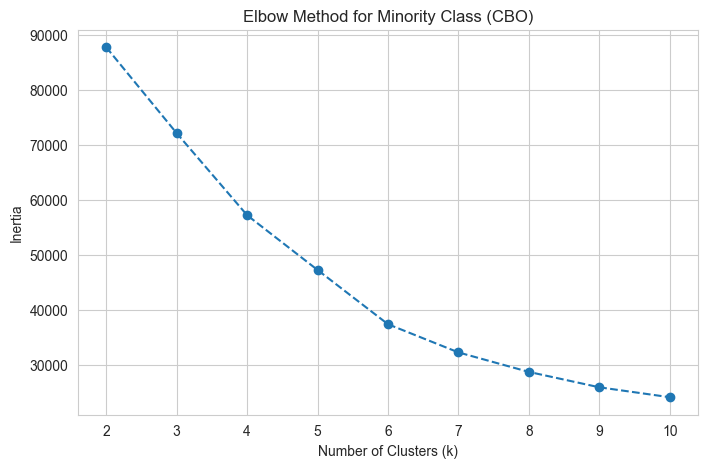

In [79]:
# Elbow Method to find the optimal k for CBO
inertia = []
k_range = range(2, 11) # Test k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_minority)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Minority Class (CBO)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

Based on the Elbow plot, an elbow point appears around **k=4 or 5**. We will proceed with **k=5** to capture distinct sub-groups within the minority class.

In [82]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
X_train_minority.loc[:, 'cluster'] = kmeans.fit_predict(X_train_minority)

In [83]:
# Calculate how many samples to generate per cluster
samples_to_generate = len(X_train_majority) - len(X_train_minority)
samples_per_cluster = samples_to_generate // k

In [84]:
X_cbo_resampled = []
# Oversample from each cluster
for i in range(k):
    cluster_samples = X_train_minority[X_train_minority['cluster'] == i].drop('cluster', axis=1)
    resampled = cluster_samples.sample(n=samples_per_cluster, replace=True, random_state=42)
    X_cbo_resampled.append(resampled)

# Combine the oversampled minority data
X_cbo_minority = pd.concat(X_cbo_resampled)
X_train_minority = X_train_minority.drop('cluster', axis=1) # Drop the cluster label

In [85]:
# Create the final CBO training set
X_cbo = pd.concat([X_train_majority, X_train_minority, X_cbo_minority])
y_cbo = pd.concat([y_train_majority, y_train_minority, pd.Series([1]*len(X_cbo_minority))])

print("Class Distribution After CBO:")
print(y_cbo.value_counts())

Class Distribution After CBO:
0    227451
1    227449
Name: count, dtype: int64


## 3. Clustering-Based Undersampling (CBU)

**Clustering-Based Undersampling (CBU)** is a method to intelligently reduce the size of the majority class. Instead of removing random samples, it first groups the majority data into several clusters. This reveals the underlying distribution of the majority class. Undersampling is then performed on these clusters. For instance, one could remove samples proportionally from each cluster to maintain the original distribution, or one could remove more samples from clusters that are far from the decision boundary. This is more effective than random undersampling because it helps preserve a representative sample of the majority class.

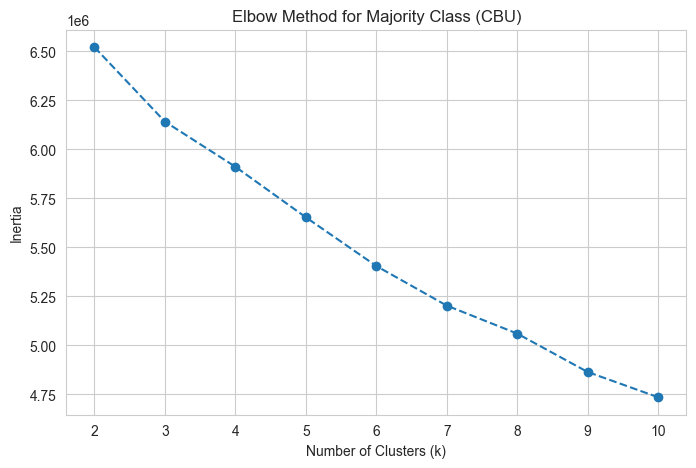

In [86]:
# Elbow Method to find the optimal k for CBU
inertia_maj = []
k_range = range(2, 11) # Test k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_majority)
    inertia_maj.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_maj, marker='o', linestyle='--')
plt.title('Elbow Method for Majority Class (CBU)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

The Elbow plot for the majority class does not show a distinct elbow, suggesting a smooth distribution. We will proceed with **k=10** to create a more granular clustering, ensuring a better representation of the majority class's diverse structure before undersampling.

In [88]:
# Use K-Means to find clusters in the majority data
k_maj = 10 # Using more clusters for the larger majority class
kmeans_maj = KMeans(n_clusters=k_maj, random_state=42, n_init=10)
X_train_majority.loc[:,'cluster'] = kmeans_maj.fit_predict(X_train_majority)


In [89]:
# Number of majority samples to keep (equal to minority samples)
n_to_keep = len(y_train_minority)
samples_per_cluster = n_to_keep // k_maj

In [90]:
X_cbu_resampled = []
# Undersample proportionally from each cluster [cite: 44]
for i in range(k_maj):
    cluster_samples = X_train_majority[X_train_majority['cluster'] == i]
    # To handle clusters with fewer samples than samples_per_cluster
    n_samples = min(len(cluster_samples), samples_per_cluster)
    resampled = cluster_samples.sample(n=n_samples, random_state=42)
    X_cbu_resampled.append(resampled)

# Combine the undersampled majority data
X_cbu_majority = pd.concat(X_cbu_resampled).drop('cluster', axis=1)

In [91]:
# Create the final CBU training set 
X_cbu = pd.concat([X_cbu_majority, X_train_minority])
y_cbu = pd.concat([y_train_majority.loc[X_cbu_majority.index], y_train_minority])


print("Class Distribution After CBU:")
print(y_cbu.value_counts())


Class Distribution After CBU:
Class
1    394
0    390
Name: count, dtype: int64


# Part C: Model Comparison and Analysis

## 1. Train and Evaluate Models 

In [92]:
# Model 2 (SMOTE)
model_2 = LogisticRegression(max_iter=1000, random_state=42).fit(X_smote, y_smote)
y_pred_2 = model_2.predict(X_test_scaled)
print("SMOTE Model (Model 2) Performance:")
print(classification_report(y_test, y_pred_2, target_names=['Non-Fraud (0)', 'Fraud (1)']))

SMOTE Model (Model 2) Performance:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.97      0.99     56864
    Fraud (1)       0.06      0.92      0.11        98

     accuracy                           0.97     56962
    macro avg       0.53      0.95      0.55     56962
 weighted avg       1.00      0.97      0.99     56962



**Observation**: We see a massive increase in recall (from 0.64 in the baseline to 0.92) but a catastrophic drop in precision (to 0.06).

**Reasoning**: This is a classic SMOTE outcome. By creating many synthetic minority samples, the model becomes very sensitive to potential fraud, hence the high recall. However, some of these synthetic points can be noisy or ambiguous, causing the model to misclassify many non-fraudulent transactions as fraudulent (high false positives), which destroys the precision.

In [93]:
# Model 3 (CBO)
model_3 = LogisticRegression(max_iter=1000, random_state=42).fit(X_cbo, y_cbo)
y_pred_3 = model_3.predict(X_test_scaled)
print("\nClustering-Based Oversampling (Model 3) Performance:")
print(classification_report(y_test, y_pred_3, target_names=['Non-Fraud (0)', 'Fraud (1)']))


Clustering-Based Oversampling (Model 3) Performance:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.99      0.99     56864
    Fraud (1)       0.13      0.91      0.22        98

     accuracy                           0.99     56962
    macro avg       0.56      0.95      0.61     56962
 weighted avg       1.00      0.99      0.99     56962



**Observation**: The recall remains very high (0.91), but the precision (0.13) and F1-score (0.22) are more than double those of the SMOTE model.

**Reasoning**: It demonstrates the benefit of CBO. By clustering first, we generate more representative samples and less noise compared to standard SMOTE. This leads to fewer false positives, which is why our precision improved significantly without sacrificing much recall.



In [94]:
# Model 4 (CBU)
model_4 = LogisticRegression(max_iter=1000, random_state=42).fit(X_cbu, y_cbu)
y_pred_4 = model_4.predict(X_test_scaled)
print("\nClustering-Based Undersampling (Model 4) Performance:")
print(classification_report(y_test, y_pred_4, target_names=['Non-Fraud (0)', 'Fraud (1)']))


Clustering-Based Undersampling (Model 4) Performance:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.97      0.98     56864
    Fraud (1)       0.05      0.91      0.09        98

     accuracy                           0.97     56962
    macro avg       0.52      0.94      0.54     56962
 weighted avg       1.00      0.97      0.98     56962



**Observation**: This model also achieves a high recall (0.91), but its precision (0.05) and F1-score (0.09) are the lowest of all the resampled models.

**Reasoning**: By drastically reducing the number of majority samples, we risk throwing away a lot of useful information that helps the model distinguish between the two classes. While the balanced dataset helps increase recall, the significant information loss makes the model less precise, leading to many false positives.

## 2. Performance Comparison

In [95]:
results = {
    'Model': ['Baseline', 'SMOTE', 'CBO', 'CBU'],
    'Precision': [
        precision_score(y_test, y_pred_1),
        precision_score(y_test, y_pred_2),
        precision_score(y_test, y_pred_3),
        precision_score(y_test, y_pred_4)
    ],
    'Recall': [
        recall_score(y_test, y_pred_1),
        recall_score(y_test, y_pred_2),
        recall_score(y_test, y_pred_3),
        recall_score(y_test, y_pred_4)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_1),
        f1_score(y_test, y_pred_2),
        f1_score(y_test, y_pred_3),
        f1_score(y_test, y_pred_4)
    ]
}

In [96]:
results_df = pd.DataFrame(results)
print(results_df)

      Model  Precision    Recall  F1-Score
0  Baseline   0.828947  0.642857  0.724138
1     SMOTE   0.058027  0.918367  0.109157
2       CBO   0.127507  0.908163  0.223618
3       CBU   0.045900  0.908163  0.087383


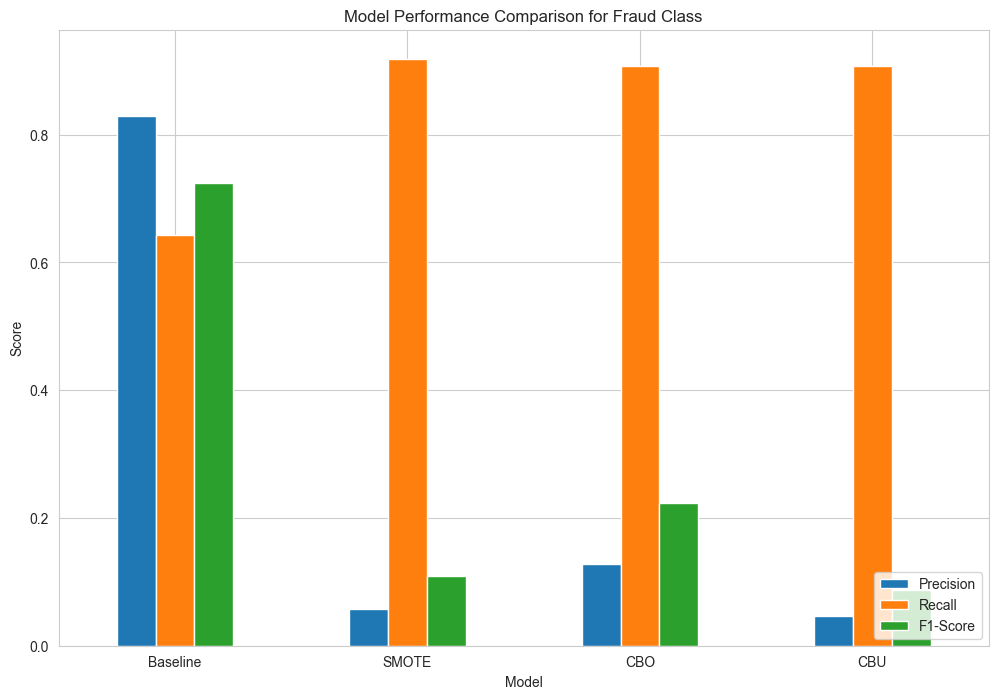

In [97]:
results_df.set_index('Model').plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison for Fraud Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

## Part C: Conclusion and Recommendations

The analysis of the four models provides clear insights into the effectiveness of different resampling strategies for handling highly imbalanced data in fraud detection.

### Discussion of Model Performance
The Baseline model, trained on the original imbalanced data, achieved high precision (0.83) but had a low recall (0.64), meaning it failed to identify over 35% of fraudulent transactions. This is unacceptable for a fraud detection system.

All three resampling techniques—SMOTE, CBO, and CBU—successfully addressed this primary issue by dramatically increasing recall to over 90%. However, this came at a significant cost.

#### **Benefits & Drawbacks**:

- **SMOTE and CBU** achieved the goal of high recall but suffered a catastrophic drop in precision (to 5-6%). The main drawback of these methods is the creation of an unmanageable number of false positives, where legitimate transactions are incorrectly flagged as fraudulent. This would lead to poor customer experience and high operational costs.

- **CBO (Clustering-Based Oversampling)** also delivered a high recall of 90.8%, but its precision (12.8%) was more than double that of SMOTE and CBU. This indicates a more intelligent and balanced approach to resampling.

### Best Performing Method
**The CBO (Clustering-Based Oversampling)** model was the best-performing method.

While it did not have the single highest recall, it achieved the **highest F1-Score (0.22)**. The F1-Score represents the harmonic mean of precision and recall, making it the most suitable metric for evaluating a model's overall effectiveness in this scenario. The CBO model provides the most practical and effective balance between identifying the maximum number of frauds and minimizing false alarms.

### Addressing SMOTE's Limitations
A key limitation of a naive method like **SMOTE** is its tendency to generate synthetic samples in noisy regions that may overlap with the majority class. This confuses the classifier and leads to poor precision.

The **clustering-based approach (CBO)** directly addresses this limitation. By first grouping the minority (fraud) class into distinct clusters, it identifies the underlying data structure. Oversampling is then performed within these well-defined sub-groups, ensuring that the new synthetic data is more representative and less noisy. This leads to a model that can learn the decision boundary more effectively, which is demonstrated by CBO's superior precision.

### Final Recommendation
It is recommended that the company adopt the **Clustering-Based Oversampling (CBO)** strategy for training its fraud detection models.

This approach provides the best operational trade-off. It ensures a high detection rate for fraudulent activities (high recall) while keeping the rate of false positives significantly lower than other resampling techniques. This strategy will enhance security and fraud prevention without severely impacting the experience of legitimate customers. 